In [ ]:
!pip install molviewspec

In [52]:
# This should be integrated to MolViewSpec soon :)

import json
from IPython.display import display, HTML, Javascript
import uuid
from io import BytesIO
import zipfile
import base64
import molviewspec as mvs
from molviewspec.builder import Root

def molstar_html(state: str, data=None):
    if data is not None:
        zip_data = BytesIO()
        with zipfile.ZipFile(zip_data, 'w') as zipf:
            zipf.writestr('index.mvsj', state)
            for path, file_contents in data.items():
                zipf.writestr(path, file_contents)
        state = 'base64,' + base64.b64encode(zip_data.getvalue()).decode('utf-8')
        format = 'mvsx'
    else:
        format = 'mvsj'

    return f'''
    <!DOCTYPE html>
    <html lang="en">
        <head>
            <!-- Replace "latest" by the specific version you want to use, e.g. "4.0.0" -->
            <script src="https://cdn.jsdelivr.net/npm/molstar@latest/build/viewer/molstar.js"></script>
            <!-- Replace "latest" by the specific version you want to use, e.g. "4.0.0" -->
            <link rel="stylesheet" type="text/css" href="https://cdn.jsdelivr.net/npm/molstar@latest/build/viewer/molstar.css" />
        </head>
        <body>
            <div id="viewer1"></div>
            <script>
                const mvsData = {json.dumps(state)};
                molstar.Viewer
                    .create('viewer1', {{ layoutIsExpanded: false, layoutShowControls: false }})
                    .then(viewer => viewer.loadMvsData(mvsData, '{format}'));
            </script>
        </body>
    </html>
    '''

def molstar_notebook(state: str, data=None, width=950, height=600):

    iframe_html = molstar_html(state, data=data)

    wrapper_id = f"molstar_{uuid.uuid4()}"

    # JavaScript code to create a Blob URL and a download link
    js_code = f"""
    setTimeout(function(){{
        var wrapper = document.getElementById("{wrapper_id}")
        if (wrapper === null) {{
            throw new Error("Wrapper element #{wrapper_id} not found anymore")
        }}
        var blob = new Blob([{json.dumps(iframe_html)}], {{ type: 'text/html' }});
        var url = URL.createObjectURL(blob);

        // Create the iframe
        var iframe = document.createElement('iframe');
        iframe.src = url;
        iframe.style = "border: 0; width: {width}px; height: {height}px"
        iframe.allow = "fullscreen";
        iframe.allowFullscreen = true;
        wrapper.appendChild(iframe);

        // Create the download link
        var link = document.createElement('a');
        link.href = url;
        link.download = "molstar_my_filename.html";
        link.innerText = "Download HTML";
        link.style.display = "block";
        link.style.marginTop = "10px";
        wrapper.appendChild(link);
    }}, 100);
    """

    # Display the iframe
    display(HTML(f'<div id="{wrapper_id}"></div>'))
    display(Javascript(js_code))

Root.molstar_notebook = lambda builder, **kwargs: molstar_notebook(builder.get_state(), **kwargs)

In [59]:
builder = mvs.create_builder()
import molviewspec as mvs

model = (
    builder.download(url='https://files.wwpdb.org/download/6vjj.cif')
    .parse(format='mmcif')
    .model_structure()
)

rep = model.component(selector={ 'label_asym_id': 'A' }).representation()
rep.color(color="white")

rep = model.component(selector={ 'label_asym_id': 'D' }).representation(type="ball_and_stick")
rep.color(color="orange")

rep = model.component(selector={ 'label_asym_id': 'A', 'auth_seq_id': 12 }).representation(type="ball_and_stick")
rep.color(color="green")

rep = model.component(selector={ 'label_asym_id': 'B' }).representation()
rep.color(color="#bbccff")

builder.molstar_notebook()

# white = KRAS
# green = "on switch" (G12C)
# orange = 5'-Guanylyl imidodiphosphate (GDPNP)
# blue = RAF1

<IPython.core.display.Javascript object>

In [54]:
import pandas as pd

position_importance = pd.read_csv('../../data/proteingym/kras_binding/rf_position_importance.csv', index_col=0)['Mean feature importance']
position_importance = position_importance.sort_values(ascending=False)
position_importance.head()

146    0.004578
19     0.004144
17     0.004123
37     0.004097
40     0.004093
Name: Mean feature importance, dtype: float64

In [60]:
builder = mvs.create_builder()
import molviewspec as mvs

model = (
    builder.download(url='https://files.wwpdb.org/download/6vjj.cif')
    .parse(format='mmcif')
    .model_structure()
)

rep = model.component(selector={ 'label_asym_id': 'A' }).representation()
rep.color(color="white")

rep = model.component(selector={ 'label_asym_id': 'D' }).representation(type="ball_and_stick")
rep.color(color="orange")

rep = model.component(selector={ 'label_asym_id': 'B' }).representation()
rep.color(color="#bbccff")

for pos, value in position_importance.head(20).items():
    residue = model.component(selector=dict(label_asym_id="A", label_seq_id=pos))
    residue.representation(type="ball_and_stick").color(color="red")

for pos, value in position_importance.tail(20).items():
    residue = model.component(selector=dict(label_asym_id="A", label_seq_id=pos))
    residue.representation(type="ball_and_stick").color(color="grey")

builder.molstar_notebook()

<IPython.core.display.Javascript object>

In [37]:
coef = pd.read_csv('../../data/proteingym/kras_binding/deconvolution_coef.csv', index_col=0)['Coef']
coef

35_T     0.634776
40_Y     0.604058
60_G     0.590423
15_G     0.582168
57_D     0.566087
           ...   
19_R    -0.380690
6_H     -0.415993
146_F   -0.424401
21_P    -0.571449
19_P    -0.778409
Name: Coef, Length: 3530, dtype: float64

In [38]:
abs_coef = coef.abs().sort_values(ascending=False)
abs_coef.head()

19_P    0.778409
35_T    0.634776
40_Y    0.604058
60_G    0.590423
15_G    0.582168
Name: Coef, dtype: float64

In [39]:
mean_abs_coef = abs_coef.groupby(abs_coef.index.map(lambda col: int(col.split('_')[0]))).mean().sort_values(ascending=False)
mean_abs_coef.head()

146    0.090959
59     0.082205
64     0.065693
55     0.061836
19     0.061802
Name: Coef, dtype: float64

<Axes: xlabel='Coef', ylabel='Mean feature importance'>

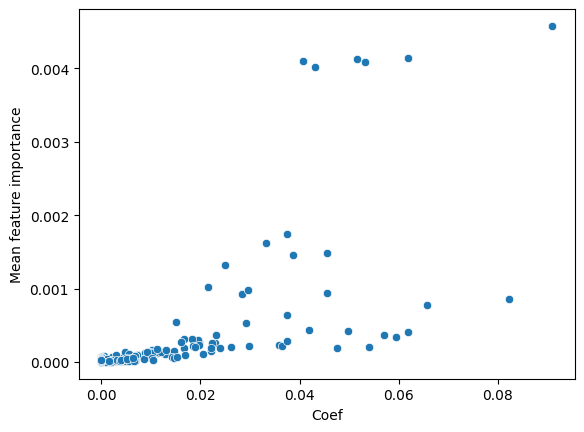

In [40]:
import seaborn as sns

sns.scatterplot(
    x=mean_abs_coef,
    y=position_importance,
)

In [61]:
builder = mvs.create_builder()
import molviewspec as mvs

model = (
    builder.download(url='https://files.wwpdb.org/download/6vjj.cif')
    .parse(format='mmcif')
    .model_structure()
)

rep = model.component(selector={ 'label_asym_id': 'A' }).representation()
rep.color(color="white")

rep = model.component(selector={ 'label_asym_id': 'D' }).representation(type="ball_and_stick")
rep.color(color="orange")

rep = model.component(selector={ 'label_asym_id': 'B' }).representation()
rep.color(color="#bbccff")

for pos, value in mean_abs_coef.head(20).items():
    residue = model.component(selector=dict(label_asym_id="A", label_seq_id=pos))
    residue.representation(type="ball_and_stick").color(color="red")

builder.molstar_notebook()

<IPython.core.display.Javascript object>